In [1]:
import gym
import energym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:
from stable_baselines3 import DQN

In [3]:
# Parameters:
years = 7

frequency = 4   # DA on every hour

gamma = 0.9
learning_starts = 35040/2   # training starts 6 months in
target_update_interval = 5000
buffer_size = 1000000
exploration_fraction = 0.8
exploration_initial_eps = 1
exploration_final_eps = 0.05
total_timesteps = years * 35040   # 7 years for training
eval_freq = 35040/2

In [4]:
########  Regular DQN run with no DA (hot environment)  ########


# Create environment:
env = gym.make('Eplus-discrete-hot-v1')

# Create model:
model = DQN("MlpPolicy", env, verbose=1, 
        gamma = gamma,
        learning_starts = learning_starts,
        target_update_interval = target_update_interval,
        buffer_size = buffer_size,
        exploration_fraction = exploration_fraction,
        exploration_initial_eps = exploration_initial_eps,
        exploration_final_eps = exploration_final_eps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
# Train model:

start_time = time.time()

model.learn(total_timesteps = total_timesteps, 
        eval_freq = eval_freq, 
        n_eval_episodes = 1)

print()
print("--- %s seconds taken to train ---" % (time.time() - start_time))


#model.save("DQN models/regular_DQN_hot")

env.close()

In [4]:
# Test model for 1 year:

model = DQN.load("DQN models/regular_DQN_hot")

env = gym.make('Eplus-discrete-hot-v1')


start_time = time.time()

for i in range(1):
    obs = env.reset()

    rewards = []
    total_power = []
    in_temp = []
    out_temp = []
    actions = []
    comfort_penalties = []
    done = False
    current_month = 0

    while not done:
        # Predict next step:
        a, _ = model.predict(obs)
        # Observe next state and reward:
        obs, reward, done, info = env.step(int(a))

        # Store information for plotting:
        rewards.append(reward)
        total_power.append(info['total_power'])
        in_temp.append(info['temperature'])
        out_temp.append(info['out_temperature'])
        actions.append(int(a))
        comfort_penalties.append(info['comfort_penalty'])

        if info['month'] != current_month: # display results every month
            current_month = info['month']
            print('Reward: ', sum(rewards), info)
    print('Episode ', i, 'Mean reward: ', np.mean(rewards), 'Cumulative reward: ', sum(rewards))
env.close()



print()
print("--- %s seconds taken to run ---" % (time.time() - start_time))

[2021-09-02 09:23:41,962] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:Creating EnergyPlus simulation environment...
[2021-09-02 09:23:41,968] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/energym/Eplus-env-discrete-hot-v1-res1/Eplus-env-sub_run1


Reward:  -0.40314488461957476 {'timestep': 900.0, 'day': 1, 'month': 1, 'hour': 0, 'total_power': 1197.281193442195, 'total_power_no_units': -0.11972811934421951, 'comfort_penalty': -0.6865616498949301, 'temperature': 19.31343835010507, 'out_temperature': 4.4}
Reward:  -1004.3411971120233 {'timestep': 2678400.0, 'day': 1, 'month': 2, 'hour': 0, 'total_power': 219.57571786594, 'total_power_no_units': -0.021957571786594, 'comfort_penalty': -0.0, 'temperature': 20.41776121899671, 'out_temperature': 12.1}
Reward:  -1466.8042189701885 {'timestep': 5097600.0, 'day': 1, 'month': 3, 'hour': 0, 'total_power': 2884.39625498143, 'total_power_no_units': -0.288439625498143, 'comfort_penalty': -0.0, 'temperature': 21.83473565479347, 'out_temperature': 11.9}
Reward:  -2146.129245633331 {'timestep': 7776000.0, 'day': 1, 'month': 4, 'hour': 0, 'total_power': 219.57571786594, 'total_power_no_units': -0.021957571786594, 'comfort_penalty': -0.0, 'temperature': 20.02358605490971, 'out_temperature': 15.3}
R

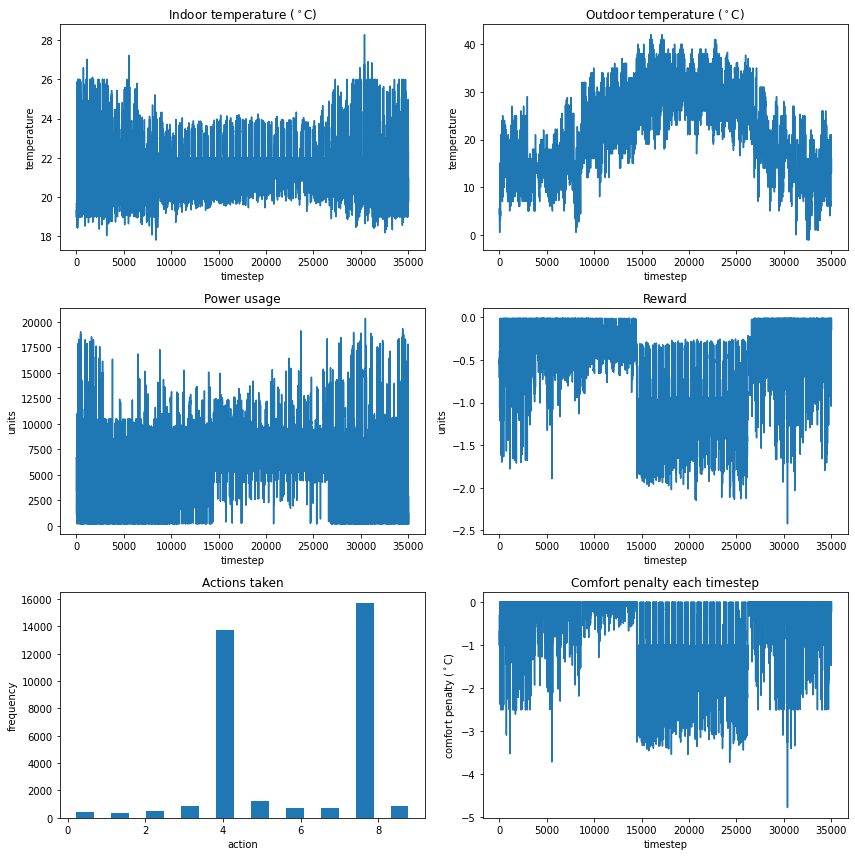

In [5]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (12,12))

axes[0,0].plot(in_temp)
axes[0,0].set_title('Indoor temperature ($^\circ$C)')
axes[0,0].set_xlabel('timestep')
axes[0,0].set_ylabel('temperature')

axes[0,1].plot(out_temp)
axes[0,1].set_title('Outdoor temperature ($^\circ$C)')
axes[0,1].set_xlabel('timestep')
axes[0,1].set_ylabel('temperature')

axes[1,0].plot(total_power)
axes[1,0].set_title('Power usage')
axes[1,0].set_xlabel('timestep')
axes[1,0].set_ylabel('units')

axes[1,1].plot(rewards)
axes[1,1].set_title('Reward')
axes[1,1].set_xlabel('timestep')
axes[1,1].set_ylabel('units')

axes[2,0].hist(actions, rwidth = 0.5)
axes[2,0].set_title('Actions taken')
axes[2,0].set_xlabel('action')
axes[2,0].set_ylabel('frequency')

axes[2,1].plot(comfort_penalties)
axes[2,1].set_title('Comfort penalty each timestep')
axes[2,1].set_xlabel('timestep')
axes[2,1].set_ylabel('comfort penalty ($^\circ$C)')


plt.tight_layout()


plt.savefig('project_images/DQN_metrics_hot.png')

In [6]:
winter = actions[33700:] + actions[:7450]
spring = actions[7450:16150]
summer = actions[16150:24900]
autumn = actions[24900:33700]

len(winter), len(spring), len(summer), len(autumn)

(8790, 8700, 8750, 8800)

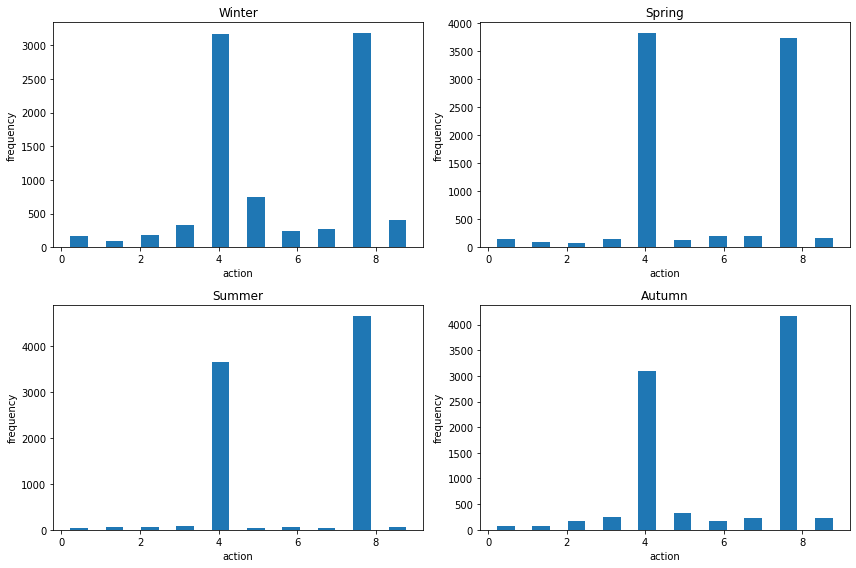

In [7]:
# split actions into seasons

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))

axes[0,0].hist(winter, rwidth = 0.5)
axes[0,0].set_title('Winter')
axes[0,0].set_xlabel('action')
axes[0,0].set_ylabel('frequency')

axes[0,1].hist(spring, rwidth = 0.5)
axes[0,1].set_title('Spring')
axes[0,1].set_xlabel('action')
axes[0,1].set_ylabel('frequency')

axes[1,0].hist(summer, rwidth = 0.5)
axes[1,0].set_title('Summer')
axes[1,0].set_xlabel('action')
axes[1,0].set_ylabel('frequency')

axes[1,1].hist(autumn, rwidth = 0.5)
axes[1,1].set_title('Autumn')
axes[1,1].set_xlabel('action')
axes[1,1].set_ylabel('frequency')


plt.tight_layout()

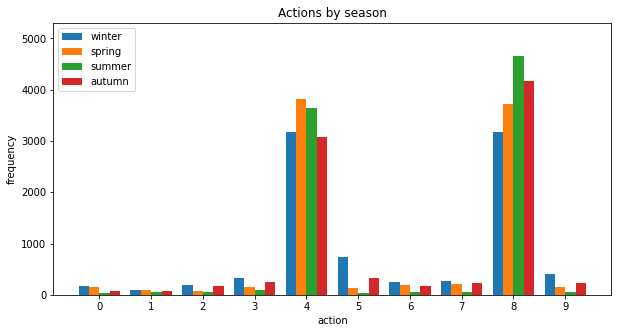

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,5))

ax.hist([winter, spring, summer, autumn], rwidth = 0.8, 
            label = ['winter', 'spring', 'summer', 'autumn'], bins = np.arange(11) - 0.5)

ax.set_title('Actions by season')
ax.set_xlabel('action')
ax.set_ylabel('frequency')

ax.legend()

ax.set_ylim([0,5300])

#ax.set(xticks=range(10), xlim=[-1, 10])

ax.set_xticks(list(range(10)))


plt.savefig('project_images/DQN_actions_by_season_hot.png')

In [9]:
print("Total comfort penalty:", sum(comfort_penalties))
print()
print("Number of comfort penalties:", sum([0 if (x == 0) else 1 for x in comfort_penalties]))

Total comfort penalty: -18223.008905444498

Number of comfort penalties: 15196


In [10]:
# See how the actions vary during the day (7am-7pm) / night (7pm-7am):



day_time_steps = [(i*96 + j) for i in range(0, 365) for j in range(28,76)]

night_time_steps = [(i*96 + j) for i in range(0, 364) for j in range(76,124)]



day_actions = [actions[day_time_steps[i]] for i in range(len(day_time_steps))]

night_actions = [actions[night_time_steps[i]] for i in range(len(night_time_steps))]


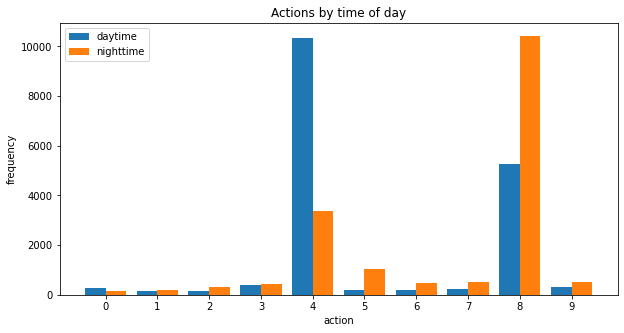

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,5))

ax.hist([day_actions, night_actions], rwidth = 0.8, 
            label = ['daytime', 'nighttime'], bins = np.arange(11) - 0.5)

ax.set_title('Actions by time of day')
ax.set_xlabel('action')
ax.set_ylabel('frequency')

ax.legend()

ax.set_xticks(list(range(10)))


plt.savefig('project_images/DQN_actions_by_time_hot.png')

In [12]:
########  DQN run with DA (hot environment) ########

In [13]:
from stable_baselines3.common.callbacks import BaseCallback

class DataAssimilationCallback(BaseCallback):
    
    def __init__(self, check_freq, actual_temp = None, actual_power = None, 
                  temp_DA = False, power_DA = False, both_DA = False, verbose=1):
        super(DataAssimilationCallback, self).__init__(verbose)
        self.check_freq = check_freq
        # Number of time the callback was called:
        self.n_calls = 0
        # Actual states after step:
        self.actual_temp = actual_temp
        self.actual_power = actual_power

        self.count = 0

        self.temp_DA = temp_DA
        self.power_DA = power_DA
        self.both_DA = both_DA



    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          if self.temp_DA:
            env.update_temp(self.actual_temp[self.count])

          elif self.power_DA:
            env.update_power(self.actual_power[self.count])

          elif self.both_DA:
            env.update_both(self.actual_temp[self.count], self.actual_power[self.count])

          self.count += 4
          

        return True    # set false for just one step

In [14]:
df = pd.read_csv("mean_runs/hot_means.csv")

df.head()

,Unnamed: 0,indoor_temp_mean,total_power_mean
0,0,20.235838,2307.147052
1,1,17.301033,3010.476952
2,2,18.275949,2923.357385
3,3,17.671280,2674.210568
4,4,19.132944,4150.169219


In [15]:
new_temps = df['indoor_temp_mean'].tolist()

new_power = df['total_power_mean'].tolist()

new_temps[:5], new_power[:5]

([20.235838084553738,
  17.301032671422092,
  18.27594937879105,
  17.67127982503697,
  19.132943983939928],
 [2307.147052247712,
  3010.4769517008085,
  2923.3573849706318,
  2674.2105678290122,
  4150.169218606896])

In [ ]:
###### Temp DA only ######


# Create environment:
env = gym.make('Eplus-discrete-hot-v1')

# Create model:
model = DQN("MlpPolicy", env, verbose=1, 
        gamma = gamma,
        learning_starts = learning_starts,
        target_update_interval = target_update_interval,
        buffer_size = buffer_size,
        exploration_fraction = exploration_fraction,
        exploration_initial_eps = exploration_initial_eps,
        exploration_final_eps = exploration_final_eps)


# Callback:
callback = DataAssimilationCallback(check_freq = frequency, actual_temp = years*new_temps, temp_DA = True)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
start_time = time.time()

model.learn(total_timesteps=total_timesteps, 
            eval_freq = eval_freq, 
            n_eval_episodes = 1, 
            callback=callback)

print()
print("--- %s seconds taken to train ---" % (time.time() - start_time))


#model.save("DQN models/temp_DA_DQN_hot")

env.close()

In [16]:
# Test model for 1 year:

model = DQN.load("DQN models/temp_DA_DQN_hot")  

env = gym.make('Eplus-discrete-hot-v1')


start_time = time.time()

for i in range(1):
    obs = env.reset()

    rewards = []
    total_power = []
    in_temp = []
    out_temp = []
    actions = []
    comfort_penalties = []
    done = False
    current_month = 0

    while not done:
        # Predict next step:
        a, _ = model.predict(obs)
        # Observe next state and reward:
        obs, reward, done, info = env.step(int(a))

        # Store information for plotting:
        rewards.append(reward)
        total_power.append(info['total_power'])
        in_temp.append(info['temperature'])
        out_temp.append(info['out_temperature'])
        actions.append(int(a))
        comfort_penalties.append(info['comfort_penalty'])

        if info['month'] != current_month: # display results every month
            current_month = info['month']
            print('Reward: ', sum(rewards), info)
    print('Episode ', i, 'Mean reward: ', np.mean(rewards), 'Cumulative reward: ', sum(rewards))
env.close()


print()
print("--- %s seconds taken to run ---" % (time.time() - start_time))

[2021-09-02 09:26:23,846] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:Creating EnergyPlus simulation environment...
[2021-09-02 09:26:23,846] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:Creating EnergyPlus simulation environment...
[2021-09-02 09:26:23,852] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/energym/Eplus-env-discrete-hot-v1-res2/Eplus-env-sub_run1
[2021-09-02 09:26:23,852] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/energym/Eplus-env-discrete-hot-v1-res2/Eplus-env-sub_run1


Reward:  -0.1978378613531864 {'timestep': 900.0, 'day': 1, 'month': 1, 'hour': 0, 'total_power': 3956.757227063728, 'total_power_no_units': -0.3956757227063728, 'comfort_penalty': -0.0, 'temperature': 20.89852933955802, 'out_temperature': 4.4}
Reward:  -886.8465818660699 {'timestep': 2678400.0, 'day': 1, 'month': 2, 'hour': 0, 'total_power': 1527.825685585969, 'total_power_no_units': -0.1527825685585969, 'comfort_penalty': -0.0, 'temperature': 21.0003102418625, 'out_temperature': 12.1}
Reward:  -1261.4548578953263 {'timestep': 5097600.0, 'day': 1, 'month': 3, 'hour': 0, 'total_power': 2833.339744459571, 'total_power_no_units': -0.28333397444595715, 'comfort_penalty': -0.0, 'temperature': 21.85207136924577, 'out_temperature': 11.9}
Reward:  -1872.6995601645979 {'timestep': 7776000.0, 'day': 1, 'month': 4, 'hour': 0, 'total_power': 275.0222381541485, 'total_power_no_units': -0.027502223815414853, 'comfort_penalty': -0.0, 'temperature': 21.18503454748426, 'out_temperature': 15.3}
Reward: 

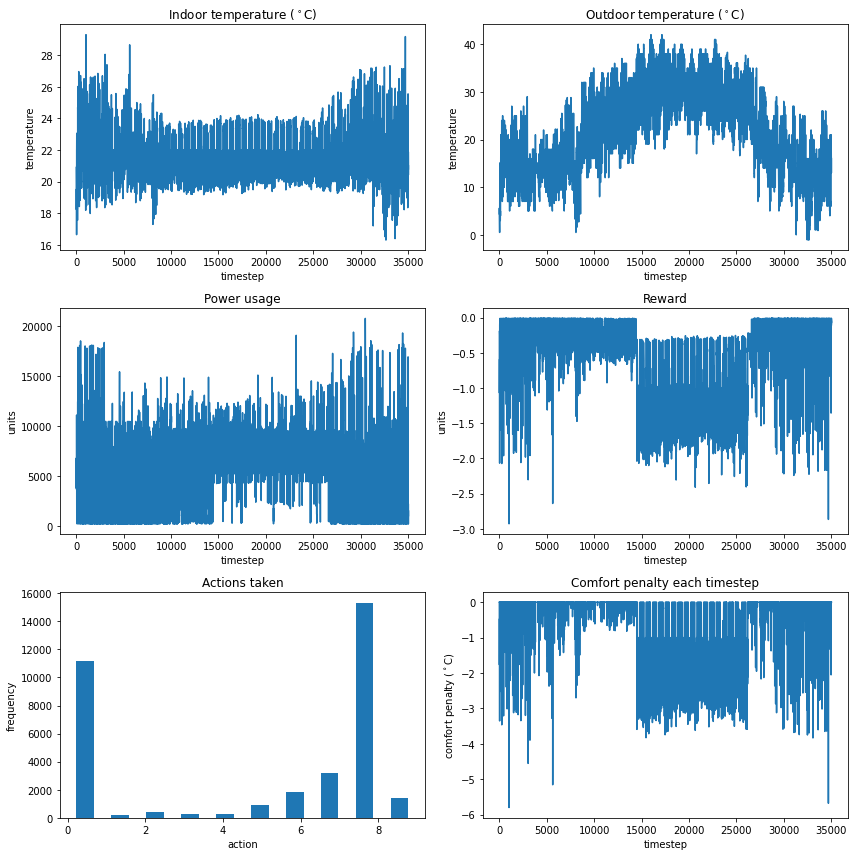

In [17]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (12,12))

axes[0,0].plot(in_temp)
axes[0,0].set_title('Indoor temperature ($^\circ$C)')
axes[0,0].set_xlabel('timestep')
axes[0,0].set_ylabel('temperature')

axes[0,1].plot(out_temp)
axes[0,1].set_title('Outdoor temperature ($^\circ$C)')
axes[0,1].set_xlabel('timestep')
axes[0,1].set_ylabel('temperature')

axes[1,0].plot(total_power)
axes[1,0].set_title('Power usage')
axes[1,0].set_xlabel('timestep')
axes[1,0].set_ylabel('units')

axes[1,1].plot(rewards)
axes[1,1].set_title('Reward')
axes[1,1].set_xlabel('timestep')
axes[1,1].set_ylabel('units')

axes[2,0].hist(actions, rwidth = 0.5)
axes[2,0].set_title('Actions taken')
axes[2,0].set_xlabel('action')
axes[2,0].set_ylabel('frequency')

axes[2,1].plot(comfort_penalties)
axes[2,1].set_title('Comfort penalty each timestep')
axes[2,1].set_xlabel('timestep')
axes[2,1].set_ylabel('comfort penalty ($^\circ$C)')


plt.tight_layout()


plt.savefig('project_images/DA_DQN_metrics_hot.png')

In [18]:
winter = actions[33700:] + actions[:7450]
spring = actions[7450:16150]
summer = actions[16150:24900]
autumn = actions[24900:33700]

len(winter), len(spring), len(summer), len(autumn)

(8790, 8700, 8750, 8800)

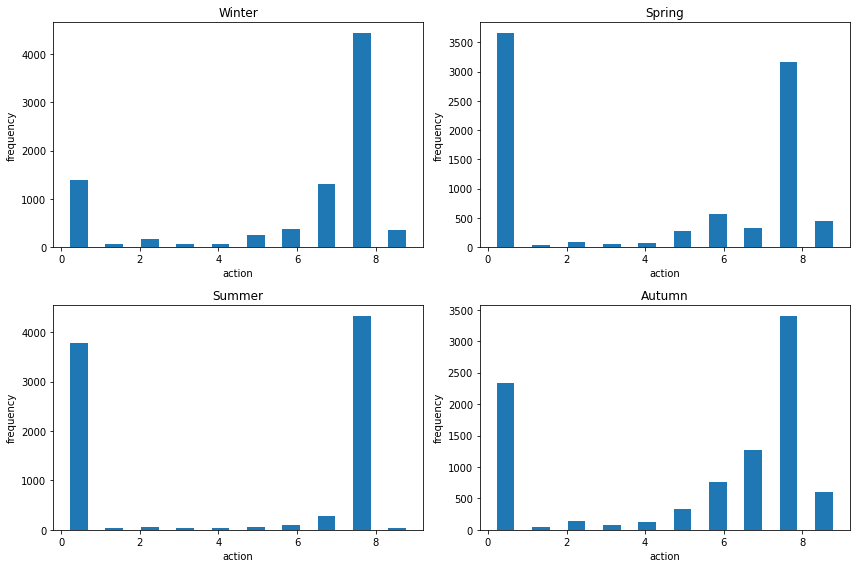

In [19]:
# split actions into seasons

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))

axes[0,0].hist(actions[34000:] + actions[:7450], rwidth = 0.5)
axes[0,0].set_title('Winter')
axes[0,0].set_xlabel('action')
axes[0,0].set_ylabel('frequency')

axes[0,1].hist(actions[7450:16150], rwidth = 0.5)
axes[0,1].set_title('Spring')
axes[0,1].set_xlabel('action')
axes[0,1].set_ylabel('frequency')

axes[1,0].hist(actions[16150:24900], rwidth = 0.5)
axes[1,0].set_title('Summer')
axes[1,0].set_xlabel('action')
axes[1,0].set_ylabel('frequency')

axes[1,1].hist(actions[24900:34000], rwidth = 0.5)
axes[1,1].set_title('Autumn')
axes[1,1].set_xlabel('action')
axes[1,1].set_ylabel('frequency')


plt.tight_layout()

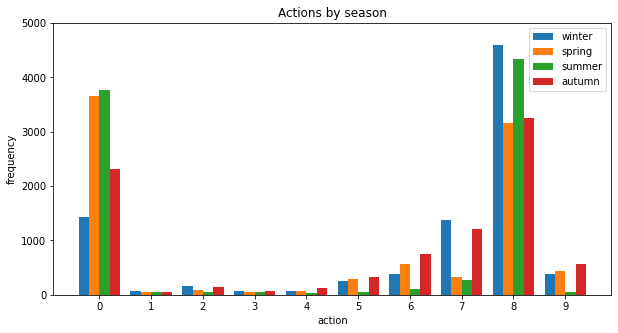

In [23]:
fig, ax = plt.subplots(nrows =1, ncols = 1, figsize = (10,5))

ax.hist([winter, spring, summer, autumn], rwidth = 0.8, 
            label = ['winter', 'spring', 'summer', 'autumn'], bins = np.arange(11) - 0.5)

ax.set_title('Actions by season')
ax.set_xlabel('action')
ax.set_ylabel('frequency')

ax.legend()

ax.set_ylim([0,5000])

ax.set_xticks(list(range(10)))


plt.savefig('project_images/DA_DQN_actions_by_season_hot.png')

In [21]:
print("Total comfort penalty:", sum(comfort_penalties))
print()
print("Number of comfort penalties:", sum([0 if (x == 0) else 1 for x in comfort_penalties]))

Total comfort penalty: -17818.15349954167

Number of comfort penalties: 12854
